In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import xgboost as xgb 
import numpy as np
from statsmodels.graphics.gofplots import qqplot_2samples
from sklearn.feature_selection import mutual_info_regression
from itertools import permutations

shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Nice labels

In [2]:
pupillo = ["Left pupil diameter", "Right pupil diameter", "Average pupil diameter", "Distance between \npupil centers", "Difference between \npupil diameters"]

non_eeg = ['ECG.',  'Resp.', 'PPG', 'SpO2', 'HR', 'Temp.']
non_eeg = [ 'Resp.', 'PPG', 'SpO$_{2}$', 'Skin Temp.', 'ECG', 'Heart Rate']
non_eeg = [ 'Resp.', 'SpO$_{2}$', 'Skin Temp.', 'Heart Rate', ]

bands = {'Delta': (1, 3),
         'Theta': (4, 7),
         'Alpha': (8, 12),
         'Beta': (13, 25),
         'Gamma': (26, 45)}

ch_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T8',
        'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6',
        'CP5', 'CP6', 'FT9', 'FT10', 'FCz', 'AFz', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2',
        'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6',
        'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'TP10']

psd_cols = [j+"_"+i for i in bands.keys() for j in ch_names]

# list_of_pm = ['pm1_palas']
list_of_pm = ['pm10_palas', 'pm4_palas', 'pm2_5_palas', 'pm1_palas', 'pmTotal_palas', 'dCn_palas']
pm_labels = {'pm10_palas': 'PM$_{10}$',
             'pm4_palas': 'PM$_{4}$',
             'pm2_5_palas': 'PM$_{2.5}$',
             'pm1_palas': 'PM$_{1}$',
             'pmTotal_palas': 'PM$_{Total}$',
             'dCn_palas': 'dCn'}
             
list_of_gas = ['nh3', 'no2', 'c3h8', 'c4h10', 'ch4', 'h2', 'c2h5oh  ']
list_of_2bnox = ['NO2', 'NO', 'NOX']

corr_labels = {'pm10_palas': 'PM$_{10}$',
             'pm4_palas': 'PM$_{4}$',
             'pm2_5_palas': 'PM$_{2.5}$',
             'pm1_palas': 'PM$_{1}$',
             'pmTotal_palas': 'PM$_{Total}$',
             'dCn_palas': 'dCn',
             'Temp.': 'Skin Temp.', #done
             'HR': 'Heart Rate', #done
             'pc_rx': 'Right PC$_{x}$',
             'SpO2': 'SpO$_{2}$', #done
             'pc_ry': 'Right PC$_{y}$',
             'PPG': 'PPG', #done
             'pda': 'Average pupil diameter',
             'pd_diff': 'Difference between \npupil diameters',
             'pd_l': 'Left pupil diameter',
             'ECG.': 'ECG', #done
             'Resp.': 'Resp.', #done
             'pc_ly': 'Left PC$_{y}$',
             'pup_dis': 'Distance between \npupil centers',
             'pc_lx': 'Left PC$_{x}$',
             'pc_rz': 'Right PC$_{z}$',
             'pc_lz': 'Left PC$_{z}$',
              'pd_r': 'Right pupil diameter'}


### Helper functions for creating models

In [3]:
parameters = {'axes.labelsize': 15,
              'axes.titlesize': 20}
plt.rcParams.update(parameters)


def XGB_model(X_train, X_test, y_train, y_test):
    # dt = xgb.DMatrix(X_train, label=y_train.values)
    # dv = xgb.DMatrix(X_test, label=y_test.values)
    dt = xgb.DMatrix(X_train, label=y_train)
    dv = xgb.DMatrix(X_test, label=y_test)
    
    params = {
        "eta": 0.1,
        "max_depth": 3,
        "objective": "reg:squarederror",
        "silent": 0,
        "base_score": np.mean(y_test),
        "eval_metric": "rmse"
    }
    model = xgb.train(params, dt, 300, [(dt, "train"),(dv, "valid")], early_stopping_rounds=10, verbose_eval=25)
    predictions = model.predict(dv)
    train_preds = model.predict(dt)
    
    return model, predictions, train_preds
def eval_results(y_test, predictions, y_train, train_preds):
    train_acc, test_acc = [], []
    mse = mean_squared_error(y_test, predictions)
    print("RMSE: ", np.sqrt(mse))
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, predictions)
    train_acc.append(train_r2)
    test_acc.append(test_r2)
    print("Train R2: ", train_r2)
    print("Test R2: ", test_r2)

    # bin_lbl = bin_labels['labels'].loc[bin_labels['bin_id'] == item].values[0]

    train_pdf = pd.DataFrame.from_dict({'Predicted': train_preds, 'Actual': y_train, 'Legend': 'Train'})
    test_pdf = pd.DataFrame.from_dict({'Predicted': predictions, 'Actual': y_test, 'Legend': 'Test'})
    full_pdf = pd.concat([train_pdf, test_pdf])
    
    return mse, train_r2, test_r2, train_acc, test_acc, full_pdf
def test_train_plot(full_pdf, y_test, train_r2, item):
    
    g = sns.jointplot(data=full_pdf, x='Predicted', y='Actual', hue='Legend', alpha=0.5, cmap="Blues", 
                          marginal_kws=dict(bw_adjust=0.2, cut=0))
    g.set_axis_labels('Predicted ' + item +' ($\mu g/m^{3}$)', 'Actual ' + item +' ($\mu g/m^{3}$)')
    g.ax_joint.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='k',label="1:1")
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles=handles, labels=[ f'Train: r$^2$={train_r2:.3f}, n={len(X_train)}', f'Test: r$^2$={test_r2:.3f}, n={len(X_test)}','1:1',], title=None)
    g.fig.suptitle(f'{item} Model \n RMSE = {np.sqrt(mse):.2f} $\mu g/m^{3}$', size=20)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    # plt.savefig(f"Plots/DUEDARE/{str(year)}/{plot_path}/PM Size/{name}/{name}.png")
    plt.show()
    
def plot_qq(full_pdf, item):
    qqplot_2samples(full_pdf['Predicted'],full_pdf['Actual'],line='45', 
                    xlabel='Predicted ' + item +' ($\mu g/m^{3}$)',  
                    ylabel='Actual ' + item +' ($\mu g/m^{3}$)')
    plt.title(f'Quantile-Quantile plot for {item}')
    # plt.savefig(f"Plots/DUEDARE/{str(year)}/{plot_path}/PM Size/{name}/{name}_qqplot.png")
    plt.show()
    
def shap_plots(model, X_test, item):
    explainer = shap.TreeExplainer(model)
    # X_test = pd.DataFrame(X_test)
    # X_test.columns = [i if i not in corr_labels.keys() else corr_labels[i] for i in features]
    # print(X_test.head)
    shap_values = explainer.shap_values(X_test)

    shap.summary_plot(shap_values, X_test, plot_type='dot', max_display=10, show=False)
    # print('part2')
    fig, ax = plt.gcf(), plt.gca()
    feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))
    # print(feature_order)
    # ax.set_yticklabels([corr_labels[i] for i in selected_columns])
    # ax.set_yticklabels([selected_columns[i] for i in feature_order])

    # ax.set_yticklabels([corr_labels[i] for i in features.columns[feature_order]])
    # plt.xlabel('Average Impact on Model')
    # plt.title(f'Feature Importance Ranking for {plot_title}{pm_labels[item]}')
    # print(f"Shap summary for {item}")
    plt.title(f'SHAP Values for {item}') 
    plt.show()

    # return feature_order
    
def sensitivityPlots(model, X_test, feature, target_pm):
    max_f = X_test[feature].max()
    # max_f = 1000
    min_f = X_test[feature].min()
    # min_f = 100
    
    num_bins = 100
    range_f = np.linspace(min_f, max_f, num_bins)
    synth_df = pd.DataFrame([X_test.drop(feature, axis=1).median()]*num_bins)
    synth_df[feature] = range_f
    synth_df = synth_df[X_test.columns]
    
    # print(X_test.columns)
    # print(synth_df.columns)
    # for feature in test_features:
    # X_test_copy[feature] = X_test[feature]
    plt.figure()
    plt.title('Sensitivity of ' + feature + ' on ' + target_pm)
    # dt = xgb.DMatrix(X_train, label=y_train.values)
    # dv = xgb.DMatrix(X_test, label=y_test.values)
    # print(synth_df.columns)
    synth_dmat = xgb.DMatrix(synth_df)
    plt.scatter(synth_df[feature], model.predict(synth_dmat), label='Predicted')
    # plt.scatter(X_test[feature], y_test, alpha=0.3, label='Actual')
    plt.xlabel(feature)
    # print(synth_df.head())
    plt.ylabel(target_pm)
    plt.legend()
    plt.show()

In [4]:
full_df = pd.read_pickle('../assets/static_bike_ride_pm.pkl')
full_df.columns = [corr_labels.get(i,i) for i in full_df.columns]
full_df.head()

,PM$_{10}$,PM$_{4}$,PM$_{2.5}$,PM$_{1}$,PM$_{Total}$,dCn,bin01_palas,bin02_palas,bin03_palas,bin04_palas,...,FT7_Gamma,FT8_Gamma,TP7_Gamma,TP8_Gamma,PO7_Gamma,PO8_Gamma,Fpz_Gamma,CPz_Gamma,POz_Gamma,TP10_Gamma
dateTime,,,,,,,,,,,,,,,,,,,,,
2021-10-21 22:37:57,10.46,3.30,1.84,0.60,48.47,17.79,0,0,0,0,...,-0.289645,-0.172489,-0.107086,0.173857,-0.820702,0.164320,-0.702439,-0.775170,-1.340020,-0.587620
2021-10-21 22:37:59,11.91,3.92,2.05,0.61,50.35,17.97,0,0,0,0,...,-0.237772,-0.288928,0.208434,-0.228651,-0.915409,-0.014305,-0.298671,-0.695625,-0.829843,-1.005162
2021-10-21 22:38:00,12.88,4.20,2.16,0.61,51.67,17.95,0,0,0,0,...,-0.274423,-0.302995,0.134113,-0.240968,-1.105099,0.265363,-0.265759,-0.681892,-0.723932,-0.871845
2021-10-21 22:38:01,16.23,4.34,2.41,0.59,56.72,17.96,0,0,0,0,...,-0.283920,-0.333639,-0.065303,-0.205010,-1.181150,-0.141889,-0.328441,-0.550778,-0.656377,-0.812218
2021-10-21 22:38:03,16.24,4.35,2.42,0.60,56.73,18.25,0,0,0,0,...,-0.324849,-0.319172,-0.532769,0.007098,-1.273774,-0.344780,-0.608975,-0.767303,-0.986956,-0.881946


### Pearson correlation matrix plot

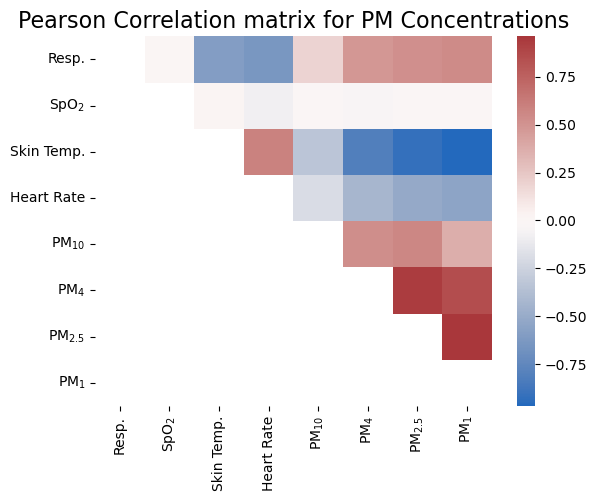

In [5]:
corr_df = full_df.loc[:,['Resp.', 'SpO$_{2}$', 'Skin Temp.', 'Heart Rate', 'PM$_{10}$', 'PM$_{4}$', 'PM$_{2.5}$', 'PM$_{1}$']].corr()
corr_sort = corr_df.reindex(corr_df.sum().sort_values(ascending=True).index)

mask = np.zeros_like(corr_df, dtype=bool)
mask[np.tril_indices_from(mask)] = True

ax = sns.heatmap(corr_df, 
                 cmap='vlag',
            mask=mask
           )

plt.title('Pearson Correlation matrix for PM Concentrations',fontsize=16)
plt.show()

### Mutual Information matrix plot

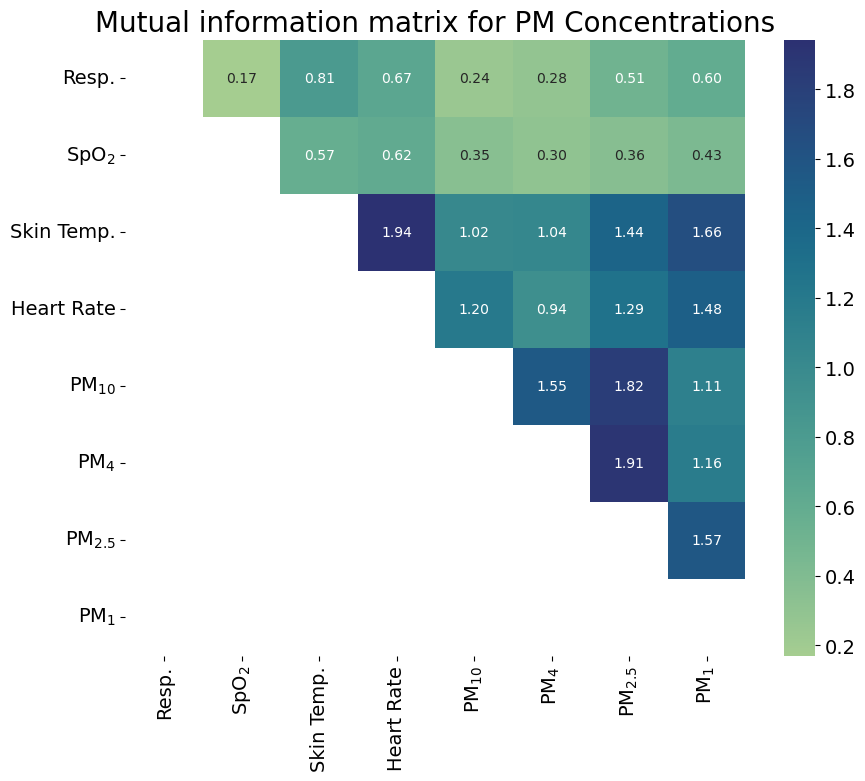

In [6]:
parameters = {'axes.labelsize': 15,
              'axes.titlesize': 20,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

def plotMutualInformationDF(df, title):
    #ECG, Resp, PPG, SpO2, HR, Temp, PM10, PM4, PM25, PM1, dCn
    # non_eeg = ['ECG.', 
    
    # for PM2.5
    # premutual_df = df.loc[:,['Temp.', 'HR', 'pup_dis', 'T8_Gamma', 'FC2_Gamma', 'FCz_Gamma', 'T8_Delta', 'FC4_Delta', 'T8_Alpha', 'F8_Alpha','pm2_5_palas']]
    
    # for PM4
    # premutual_df = df.loc[:,['Temp.', 'HR', 'pup_dis', 'FCz_Gamma', 'CP2_Gamma', 'P7_Beta', 'C2_Gamma', 'AF8_Delta', 'T8_Theta', 'FC2_Gamma', 'pm4_palas']]
    
    # for PM10
    # premutual_df = df.loc[:,['C1_Gamma','Temp.','T8_Delta','HR','T8_Gamma','FC2_Gamma','F8_Beta','C2_Gamma','FCz_Gamma','FC1_Gamma','pm10_palas']]
    stylized_pm = ['PM$_{10}$','PM$_{4}$','PM$_{2.5}$','PM$_{1}$']
    premutual_df = df.loc[:,non_eeg + stylized_pm]
    order_of_cols = premutual_df.columns
    
    # combines = list(combinations(premutual_df.columns, 2))
    combines = list(permutations(premutual_df.columns,2))
    
    
    
    mi_list = []
    for i in combines:
        # print(i)

        mi = mutual_info_regression(df.loc[:,i[0]].to_numpy().reshape(-1,1), df.loc[:,i[1]].to_numpy())
        mi_list.append(mi)
        # print(f"Mutual information between {i[0]} and {i[1]} is: {mi}")
    
    mi_df = pd.DataFrame({'Var1': [i[0] for i in combines], 'Var2': [i[1] for i in combines], 'Mutual Information': [i[0] for i in mi_list]})
    mi_df = mi_df.pivot(index='Var1', columns='Var2', values='Mutual Information')
    # mi_df = mi_df.sort_values(by=['Mutual Information'])
#     sorted_cols = mi_df.isna().sum().sort_values(ascending=False).index
#     mi_df = mi_df.reindex(columns=sorted_cols)
    # mi_df = mi_df.reindex(['Temp.', 'HR', 'pup_dis', 'T8_Gamma', 'FC2_Gamma', 'FCz_Gamma', 'T8_Delta', 'FC4_Delta', 'T8_Alpha', 'F8_Alpha','pm2_5_palas'])
    # mi_df = mi_df.reset_index(['Temp.', 'HR', 'pup_dis', 'T8_Gamma', 'FC2_Gamma', 'FCz_Gamma', 'T8_Delta', 'FC4_Delta', 'T8_Alpha', 'F8_Alpha','pm2_5_palas'])
    mi_df = mi_df.reindex(order_of_cols)
    mi_df = mi_df.reindex(columns=order_of_cols)
    
    fig, ax = plt.subplots(figsize=(10,8))

    mask = np.zeros_like(corr_df, dtype=bool)
    mask[np.tril_indices_from(mask)] = True

    ax = sns.heatmap(mi_df, cmap='crest', mask=mask, annot=True, fmt=".2f")
    
    # [i if i not in corr_labels.keys() else corr_labels[i] for i in selected_columns]
    ax.set_yticklabels([i if i not in corr_labels.keys() else corr_labels[i] for i in mi_df.index])
    ax.set_xticklabels([i if i not in corr_labels.keys() else corr_labels[i] for i in mi_df.index])
#     # ax.set_yticklabels([corr_labels[i] for i in corr_sort.index])
#     # ax.set_xticklabels([corr_labels[i] for i in full_df.loc[:,['ECG.','HR', 'Temp.'] + list_of_pm].columns])
    plt.ylabel('')
    plt.xlabel('')
    # title = 'PM_${2.5}$'
    plt.title('Mutual information matrix for PM Concentrations')
    plt.show()
    
    # return fig
    # return mi_df

plotMutualInformationDF(full_df, '2022')

### Causal Effect 

In [7]:
few_biometrics = pd.read_csv('../assets/traversal_order_biometrics.csv')
few_biometrics

,Skin Temp.,Heart Rate,Resp.,SpO$_{2}$,PPG
0,31.2500,87,29.114576,0.000100,16611.000523
1,31.1875,90,28.610229,0.000099,16328.999773
2,31.2500,90,29.068727,0.000099,16719.000414
3,31.1250,92,28.610229,0.000099,16228.999943
4,31.3125,93,29.068727,0.000099,16320.999712
...,...,...,...,...,...
1378,30.8750,101,37.367526,0.000100,16769.999638
1379,30.8750,103,35.120890,0.000100,16274.999827
1380,30.8750,98,36.312982,0.000100,16504.000872
1381,30.8750,98,36.496382,0.000099,16633.000225


In [8]:
input_features = np.array(few_biometrics.values.T)  # Transpose to get each column as a vector
features = few_biometrics.copy()
target_variable = full_df.loc[:, 'PM$_{2.5}$'].values

In [9]:
# Initialize an empty set S
S = set()
result_list = []
# Loop through all input features

def joint_entropy_nd(args, bins):
    # bin data, count number in each bin
    binned_dist, _ = np.histogramdd(args, bins=bins)

    # normalize counts to give probabilities
    probs = binned_dist / np.sum(binned_dist)

    # get rid of bins with 0
    probs = probs[np.nonzero(probs)]

    # calculate joint entropy
    joint_entropy = -np.sum(probs * np.log2(probs))

    return joint_entropy

your_bin_value = 6

for i in range(len(input_features)):
    # Take feature i
    current_feature = input_features[i]

    # Put arguments to the function joint_entropy_nd
    args_to_check_1 = [input_features[j] for j in S] + [current_feature, target_variable]
    args_to_check_2 = [input_features[j] for j in S] + [current_feature]
    args_to_check_3 = [input_features[j] for j in S] + [target_variable]
    args_to_check_4 = [input_features[j] for j in S]

    # Calculate joint entropy directly without storing the entire distribution
    result_1 = joint_entropy_nd(args_to_check_1, bins=your_bin_value) - joint_entropy_nd(args_to_check_2, bins=your_bin_value)

    # Conditionally calculate result_2 based on the value of i
    if i == 0:
        result_2 = joint_entropy_nd(args_to_check_3, bins=your_bin_value)
    else:
        result_2 = joint_entropy_nd(args_to_check_3, bins=your_bin_value) - joint_entropy_nd(args_to_check_4, bins=your_bin_value)

    result = result_2 - result_1
    print(features.columns[i], result)

    # Check if result is not equal to 0
    # if result != 0:
        # If yes, add the entire current_feature to S
    result_list.append(result)
    S.add(i)  # Convert to tuple to make it hashable

# S now contains the selected input features
print(S)

Skin Temp. 1.3036540864250803
Heart Rate 0.13698566700216874
Resp. 0.09341838252078727
SpO$_{2}$ 0.0557757525177589
PPG 0.02203610097971964
{0, 1, 2, 3, 4}


FixedFormatter should only be used together with FixedLocator


[Text(0, 0, 'Skin Temp.'),
 Text(1, 0, 'Heart Rate'),
 Text(2, 0, 'Resp.'),
 Text(3, 0, 'SpO$_{2}$'),
 Text(4, 0, 'PPG')]

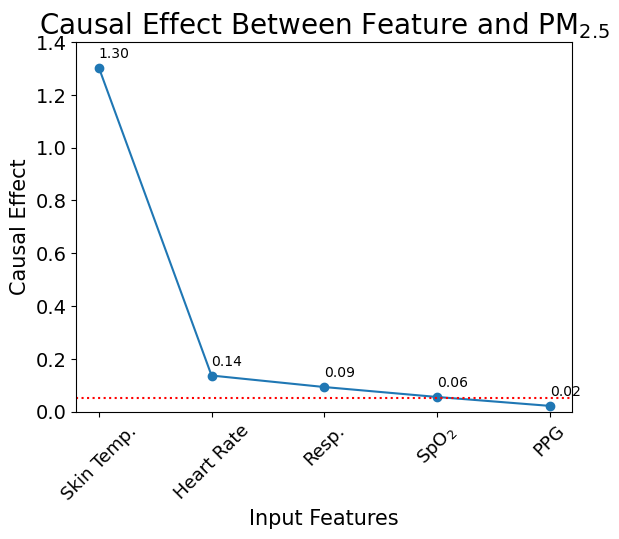

In [10]:
full_feats = full_df.loc[:,[ 'Resp.', 'PPG', 'SpO$_{2}$', 'Skin Temp.','Heart Rate']]
mi_dict = dict(zip(full_feats.columns, mutual_info_regression(full_feats, target_variable)))
mi_dict_sorted = dict(sorted(mi_dict.items(), key=lambda item: item[1], reverse=True))
fig, ax = plt.subplots()

ax.plot(list(mi_dict_sorted.keys()), result_list, marker='o')
for i, txt in enumerate(result_list):
    plt.text(list(mi_dict_sorted.keys())[i], result_list[i]+0.08, f'{result_list[i]:.2f}', ha='left', va='top')
ax.set_ylabel('Causal Effect')
ax.set_xlabel('Input Features')
ax.set_title('Causal Effect Between Feature and PM$_{2.5}$')
ax.axhline(y=0.05, color='r', linestyle='dotted')
plt.ylim(0,1.4)
ax.set_xticklabels(list(mi_dict_sorted.keys()), rotation=45,  fontsize=13)

### PM<sub>2.5</sub> ML Model with all features

Pass `evals` as keyword args.


[17:06:58] WARNING: D:\bld\xgboost-split_1691123240256\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:1.95760	valid-rmse:1.93915
[25]	train-rmse:0.46738	valid-rmse:0.53166
[50]	train-rmse:0.34942	valid-rmse:0.45545
[75]	train-rmse:0.29366	valid-rmse:0.43257
[100]	train-rmse:0.25195	valid-rmse:0.41746
[125]	train-rmse:0.21541	valid-rmse:0.40098
[150]	train-rmse:0.18985	valid-rmse:0.39224
[175]	train-rmse:0.16754	valid-rmse:0.38451
[200]	train-rmse:0.14532	valid-rmse:0.37797
[225]	train-rmse:0.12788	valid-rmse:0.37222
[250]	train-rmse:0.11116	valid-rmse:0.36505
[275]	train-rmse:0.09906	valid-rmse:0.36342
[299]	train-rmse:0.08894	valid-rmse:0.36038
RMSE:  0.36038079737942996
Train R2:  0.9982939248998931
Test R2:  0.9715718566840782


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


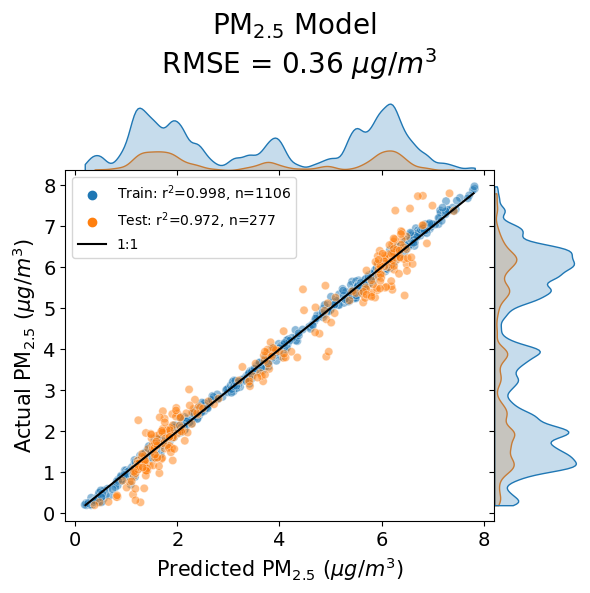

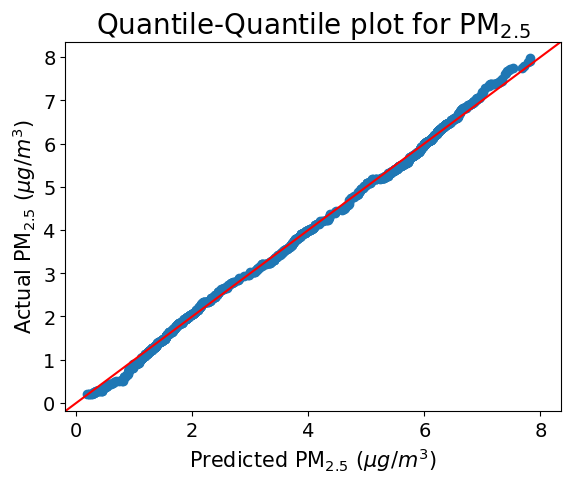

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


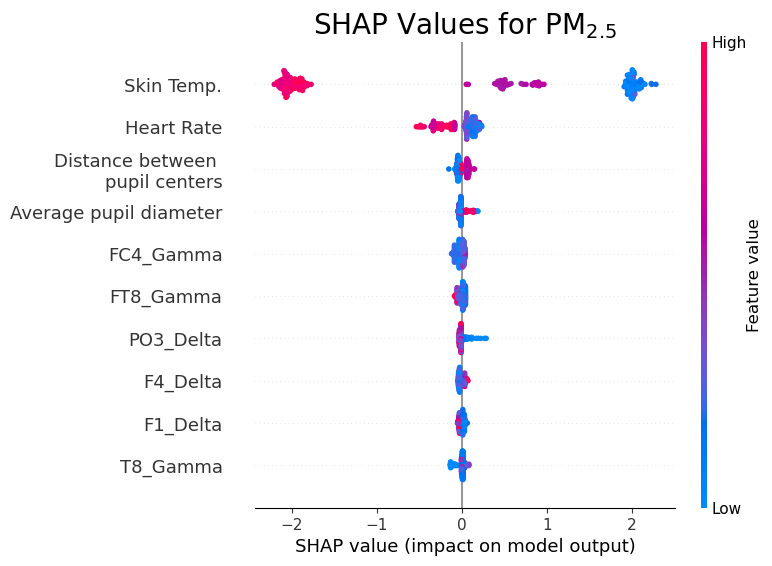

In [11]:
list_of_pm = ['PM$_{10}$', 'PM$_{4}$', 'PM$_{2.5}$', 'PM$_{1}$', 'PM$_{Total}$','dCn']
target_pm = 'PM$_{2.5}$'
non_eeg = [ 'Resp.','SpO$_{2}$', 'Skin Temp.','Heart Rate']
features = full_df.loc[:,non_eeg+pupillo+psd_cols]
targets = full_df.loc[:,target_pm]
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=1)
model, predictions, train_preds = XGB_model(X_train, X_test, y_train, y_test)
mse, train_r2, test_r2, train_acc, test_acc, full_pdf = eval_results(y_test, predictions, y_train, train_preds)
test_train_plot(full_pdf, y_test, train_r2, target_pm)
plot_qq(full_pdf, target_pm)
shap_plots(model, X_test, target_pm)

### PM<sub>2.5</sub> with easily-collectible biometric features

[17:07:02] WARNING: D:\bld\xgboost-split_1691123240256\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:1.95892	valid-rmse:1.94229
[25]	train-rmse:0.51092	valid-rmse:0.52659
[50]	train-rmse:0.44429	valid-rmse:0.46412
[75]	train-rmse:0.42094	valid-rmse:0.44474
[100]	train-rmse:0.40742	valid-rmse:0.43557
[125]	train-rmse:0.39408	valid-rmse:0.42847
[150]	train-rmse:0.37848	valid-rmse:0.41839
[175]	train-rmse:0.36896	valid-rmse:0.41267
[200]	train-rmse:0.35878	valid-rmse:0.40763
[225]	train-rmse:0.35005	valid-rmse:0.40422
[244]	train-rmse:0.34483	valid-rmse:0.40357


Pass `evals` as keyword args.


RMSE:  0.4032576114070356
Train R2:  0.9743876253928907
Test R2:  0.9644048883766755


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


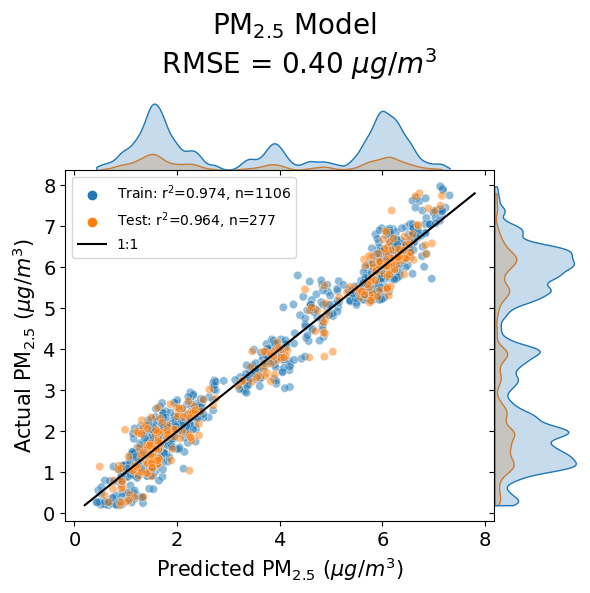

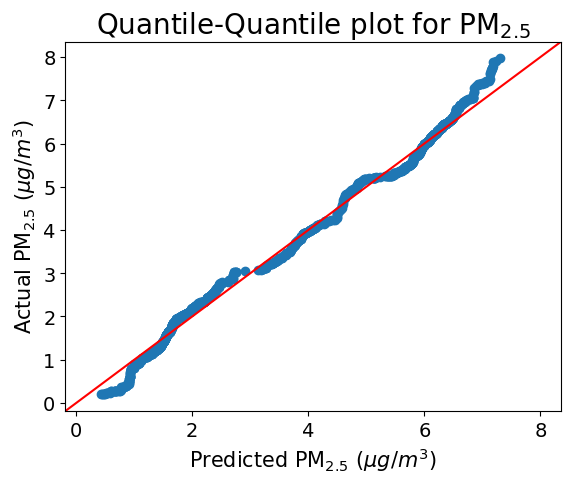

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


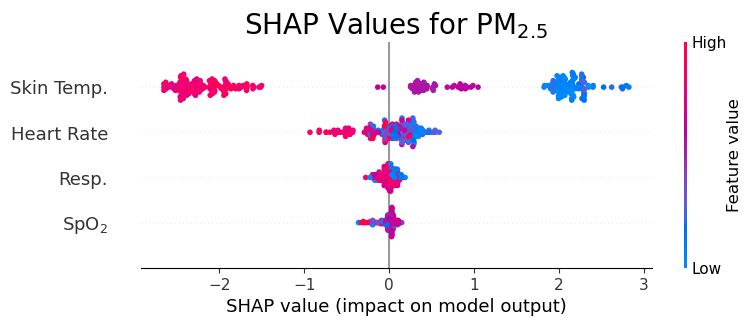

In [12]:
list_of_pm = ['PM$_{10}$', 'PM$_{4}$', 'PM$_{2.5}$', 'PM$_{1}$', 'PM$_{Total}$','dCn']
target_pm = 'PM$_{2.5}$'
non_eeg = [ 'Resp.','SpO$_{2}$', 'Skin Temp.','Heart Rate']
features = full_df.loc[:,non_eeg]
targets = full_df.loc[:,target_pm]
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=1)
model, predictions, train_preds = XGB_model(X_train, X_test, y_train, y_test)
mse, train_r2, test_r2, train_acc, test_acc, full_pdf = eval_results(y_test, predictions, y_train, train_preds)
test_train_plot(full_pdf, y_test, train_r2, target_pm)
plot_qq(full_pdf, target_pm)
shap_plots(model, X_test, target_pm)